# Imports

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torchvision import datasets
from torchvision import transforms
import torchvision.transforms.functional as TF
from torchvision import utils
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torch.utils.data import random_split
import torchvision.models
import PIL
from PIL import Image

In [18]:
%matplotlib inline
sns.set_style("dark")

# Data Visualization

In [19]:
l="abc".upper()
n=range(3)

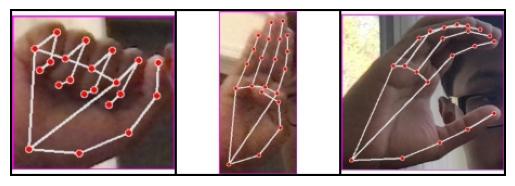

In [21]:
root="/kaggle/input/asl-data/Train/Train"
imgs=[]
labels=[]

for i in range(3):
    
    cls_directory=os.path.join(root,label_to_class[i])
    image_path=os.path.join(cls_directory,label_to_class[i]+"1.jpg")
    img=Image.open(image_path)
    img=TF.to_tensor(img)
    imgs.append(img)
    labels.append(label_to_class[i])
    
imgs=utils.make_grid(imgs,nrow=8)
np.array(imgs)
imgs=np.transpose(np.array(imgs),(1,2,0))
plt.imshow(imgs);
plt.axis("off");
plt.savefig("1.jpg")

# Dataset

In [22]:
root="/kaggle/input/asl-data/Train/Train"

#ImageNet Dataset mean and std
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data=datasets.ImageFolder(root, transform=transforms.Compose([transforms.Resize(224),
                                                              transforms.ToTensor(),
                                                              transforms.Normalize(mean,std)]))

In [23]:
def show(imgs):
    imgs=np.array(imgs)
    imgs=imgs.transpose(1,2,0)*std+mean
    imgs=np.clip(imgs,0,1)
    plt.imshow(imgs)
    plt.axis("off")

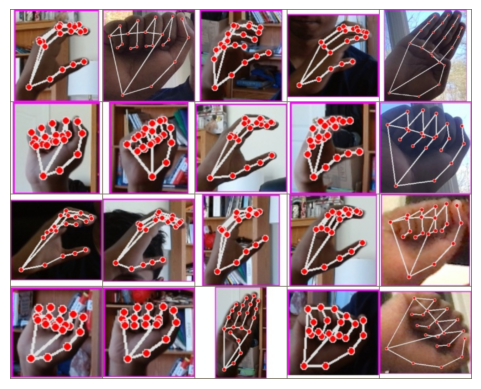

In [24]:
indexs=np.random.choice(range(len(data)),20,replace=False)

imgs=[data[i][0] for i in indexs]
labels=[data[i][1] for i in indexs]

imgs=utils.make_grid(imgs,nrow=5)
show(imgs)
plt.savefig("2.jpg")

# Dataloader

In [25]:
train_idx,val_idx=train_test_split(range(len(data)),test_size=0.4)

train_ds=Subset(data,train_idx)
val_ds=Subset(data,val_idx)

train_dl=DataLoader(train_ds,batch_size=8,shuffle=True,num_workers=2)
val_dl=DataLoader(val_ds,batch_size=16,shuffle=True,num_workers=2)

# Model

In [26]:
from torchvision.models import vgg11_bn,VGG11_BN_Weights

In [27]:
vgg=vgg11_bn(weights=VGG11_BN_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:01<00:00, 270MB/s]  


In [28]:
class VGG(nn.Module):
    def __init__(self,out_features):
        super().__init__()
        
        self.out_features=out_features
        self.in_features=list(vgg.children())[2][-1].in_features
        
        self.body=nn.Sequential(*list(vgg.children())[:-1])
        self.head=nn.Sequential(*list(vgg.children())[2][:-1])
        
        self.classification=nn.Linear(self.in_features,self.out_features)
        
    def forward(self,x):
        x=self.body(x)
        x=x.view(x.size(0),-1)
        x=self.head(x)
        x=self.classification(x)
        
        return x

In [29]:
device=("cuda" if torch.cuda.is_available() else "cpu")

model=VGG(len(label_to_class))
model.to(device)

for params in list(model.parameters())[:-2]:
    params.requires_grad=False

In [30]:
loss_fn=nn.CrossEntropyLoss(reduction="sum")
optim=torch.optim.Adam(list(model.parameters())[-2:],lr=0.0001)

# Training

In [31]:
losses={"train_loss":[],"val_loss":[],"train_metric":[],"val_metric":[]}

train_len=len(train_dl.dataset)
val_len=len(val_dl.dataset)
epochs=15

for i in range(epochs):
    model.train()
    
    train_loss=0.0
    train_accuracy=0.0
    val_loss=0.0
    val_accuracy=0.0
    
    for x,y in train_dl:
        x,y=x.to(device),y.to(device)
        pred=model(x)
        loss=loss_fn(pred,y)
        
        train_loss+=loss_fn(pred,y).item()
        pred_labels=pred.argmax(dim=1)
        train_accuracy+=(pred_labels==y).sum().item()
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
    model.eval()
    with torch.no_grad():
        for x,y in val_dl:
            x,y=x.to(device),y.to(device)
            pred=model(x)
            loss=loss_fn(pred,y)
            
            val_loss+=loss_fn(pred,y).item()
            pred_labels=pred.argmax(dim=1)
            val_accuracy+=(pred_labels==y).sum().item()
            
    print(f"{i+1}/{epochs} Epoch: \n\n train loss:{train_loss/train_len} \n val loss: {val_loss/val_len} \n")
    print(f"train accuracy:{train_accuracy/train_len} \n val accuracy: {val_accuracy/val_len} \n")
    print("*"*30+"\n")
            
    losses["train_loss"].append(train_loss/train_len)
    losses["val_loss"].append(val_loss/val_len)
    losses["train_metric"].append(train_accuracy/train_len)
    losses["val_metric"].append(val_accuracy/val_len)

1/15 Epoch: 

 train loss:1.4211975316338192 
 val loss: 0.7312379750874963 

train accuracy:0.6026490066225165 
 val accuracy: 0.8762376237623762 

******************************

2/15 Epoch: 

 train loss:0.6202798627859709 
 val loss: 0.46516345603631276 

train accuracy:0.8675496688741722 
 val accuracy: 0.905940594059406 

******************************

3/15 Epoch: 

 train loss:0.456691079483127 
 val loss: 0.363892925847875 

train accuracy:0.8807947019867549 
 val accuracy: 0.9306930693069307 

******************************

4/15 Epoch: 

 train loss:0.36388202317503116 
 val loss: 0.3049927203371973 

train accuracy:0.9205298013245033 
 val accuracy: 0.9331683168316832 

******************************

5/15 Epoch: 

 train loss:0.2946960986252652 
 val loss: 0.27622749759714205 

train accuracy:0.9387417218543046 
 val accuracy: 0.9282178217821783 

******************************

6/15 Epoch: 

 train loss:0.26986727503356556 
 val loss: 0.24824654819941758 

train accuracy:

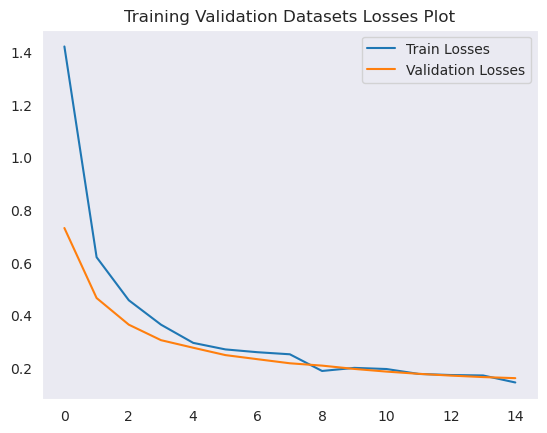

In [32]:
sns.lineplot(x=range(epochs),y=losses['train_loss'],label="Train Losses");
sns.lineplot(x=range(epochs),y=losses['val_loss'],label="Validation Losses");
plt.title("Training Validation Datasets Losses Plot");
plt.legend();
plt.savefig("3.jpg")

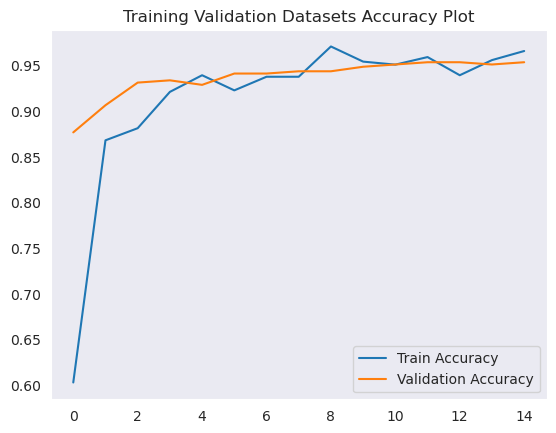

In [33]:
sns.lineplot(x=range(epochs),y=losses['train_metric'],label="Train Accuracy");
sns.lineplot(x=range(epochs),y=losses['val_metric'],label="Validation Accuracy");
plt.title("Training Validation Datasets Accuracy Plot");
plt.legend();
plt.savefig("4.jpg")